# Introduction

In this chanllenge, Santander invites Kagglers to help them identify which customers will make a specific transaction in the future, irrespective of the amount of money transcated. The data provided for this competiton has the same structure as the real data they have available to solve this problem.

The data is anonimyzed, each row containing 200 numerical values identified just with a number.

In the following we will explore the data, prepare it for a model, train a model and predict the target value for the test set, then prepare a submission.

Stay tuned, I will frequently update this Kernel in the next days.

## Prepare for data analysis

In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:47: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Load data

In [2]:
IS_LOCAL = True
if(IS_LOCAL):
    PATH="./"
else:
    PATH="../input/"
os.listdir(PATH)

['test.csv',
 'submission.csv',
 'FI.png',
 'Santander EDA and Prediction.ipynb',
 'train.csv',
 '.ipynb_checkpoints',
 'sample_submission.csv']

In [3]:
# %%time
train_df = pd.read_csv(PATH+"train.csv")
test_df = pd.read_csv(PATH+"test.csv")

# Data Exploration

## Check the data

Let's check the train and the test set.

In [4]:
train_df.shape, test_df.shape

((200000, 202), (200000, 201))

Both train and test data have 200,000 entries and 202, respectivelly 201 columns.
Let's glimpse train and test dataset.

In [5]:
train_df.tail()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
199995,train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001
199999,train_199999,0,10.8762,-5.7105,12.1183,8.0328,11.5577,0.3488,5.2839,15.2058,...,8.9842,1.6893,0.1276,0.3766,15.2101,-2.4907,-2.2342,8.1857,12.1284,0.1385


In [6]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


Train contains:

- ID_code (string)
- target;
- 200 numerical variables, named from var_0 to var_199

Test contains:

- ID_code (string)
- 200 numerical vairables, named to var_0 to var_199

Let's check if there are any missing data. We will also check the type of data.

We check first train.

In [7]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [8]:
%%time
missing_data(train_df)

CPU times: user 1.81 s, sys: 144 ms, total: 1.96 s
Wall time: 1.96 s


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [9]:
%%time
missing_data(test_df)

CPU times: user 1.69 s, sys: 58.8 ms, total: 1.75 s
Wall time: 1.75 s


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


There are no missing data in train and test datasets. Let's check the numerical values in train and test dataset.

In [10]:
%%time
train_df.describe()

CPU times: user 2.02 s, sys: 139 ms, total: 2.16 s
Wall time: 2.15 s


,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [11]:
%time
test_df.describe()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


We can make few observations here:

- standard deviation is relatively large for both train and test vaiable data
- min, max, mean, std values for trian and test data looks quite close
- mean values are distributed over a large range

The number of values in train and test set is the same. Let's plot the scatter plot for train and teset set for few of the features.

In [12]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();

We will show just 5% of the data. On x axis we shwo train values and on the y axis we show the test values.

<Figure size 432x288 with 0 Axes>

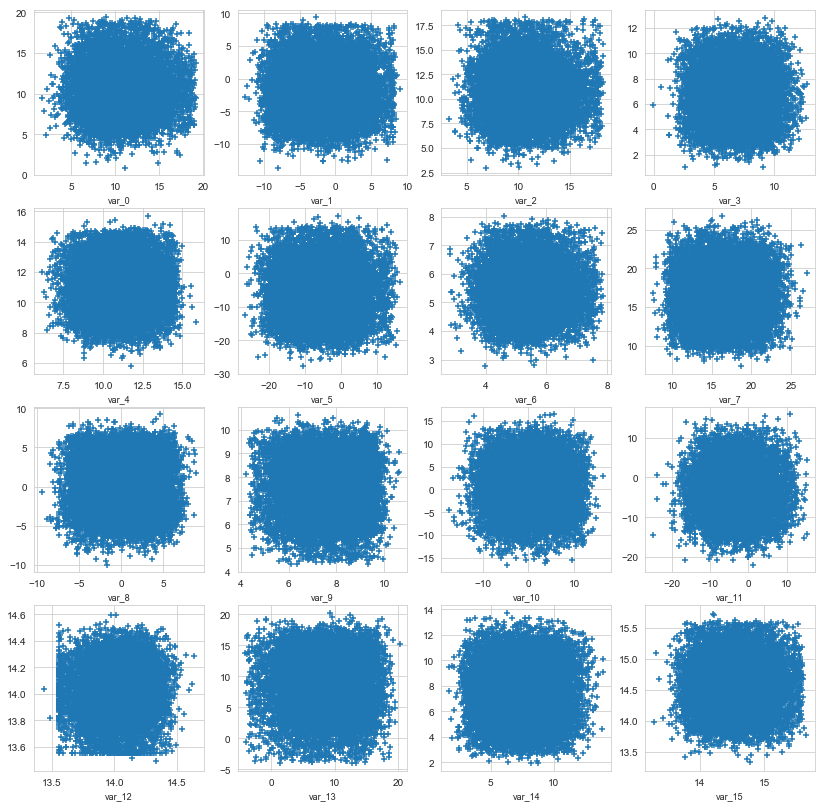

In [13]:
features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 
           'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15', 
           ]
plot_feature_scatter(train_df[::20],test_df[::20], features)

Let's check the distribution of target value in train dataset.

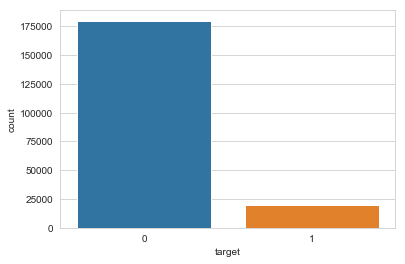

In [ ]:
sns.countplot(train_df['target'])

In [ ]:
print("There are {}% target values with 1".format(100 * train_df["target"].value_counts()[1]/train_df.shape[0]))

There are 10.049% target values with 1


The data is unbalanced with respect with target value.

## Density plots of features

Let's show now the density plot of variables in train dataset.

We represent with different colors the distribution for values with target value 0 and 1

In [ ]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

The first 100 values are displayed in the following cell

<Figure size 432x288 with 0 Axes>

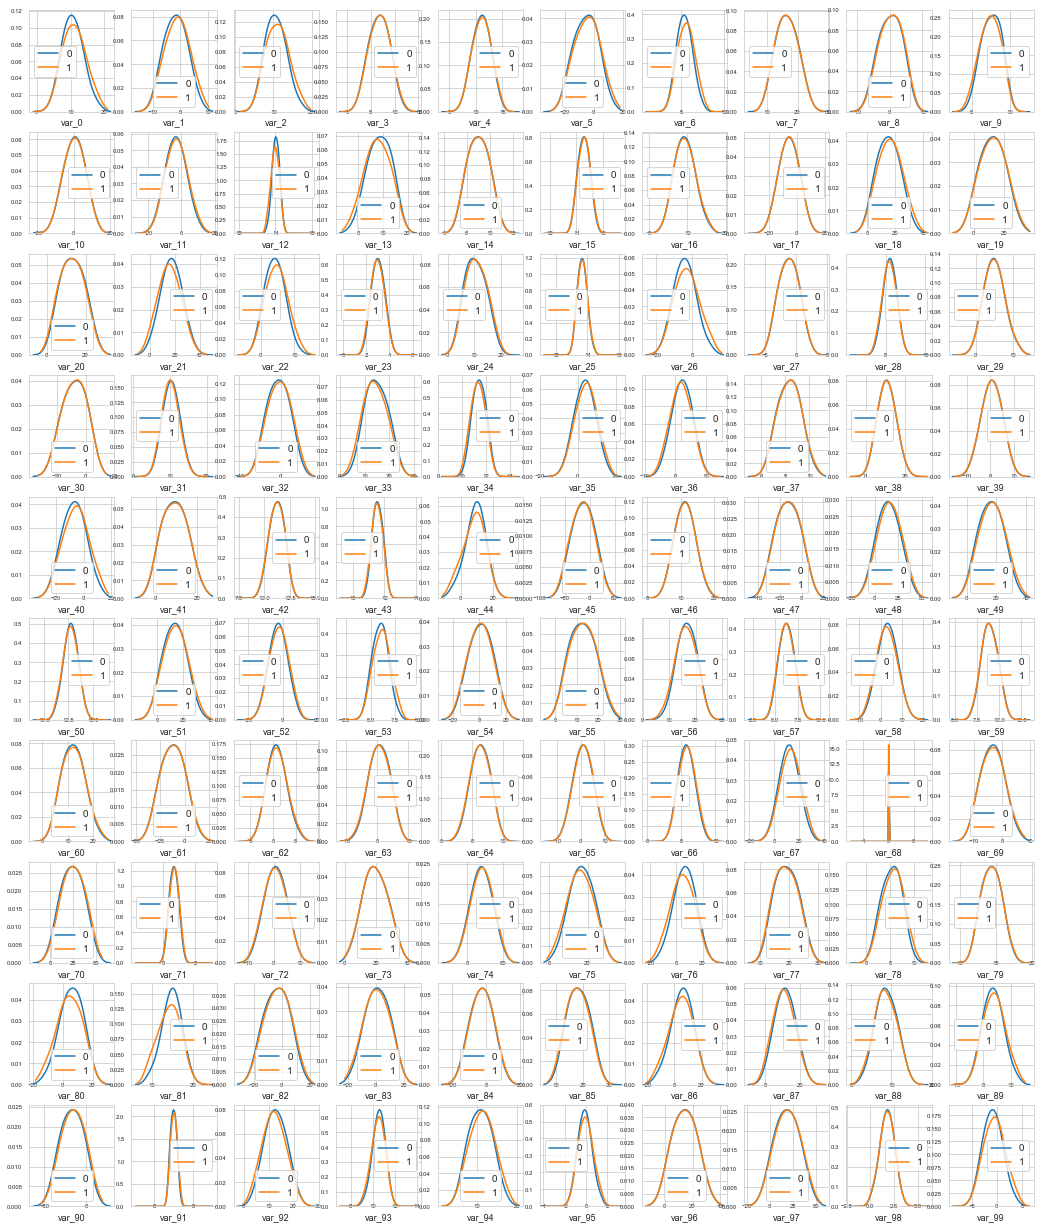

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

In [ ]:
features = train_df.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

We can observe that there is a considerable number of features with significant differentt distribution for the tow target values.

For example, var_0, var_1, var_2, var_5, var_9, var_13, var_106, var_109, var_139 and many others.

Also some features, like var_2, var_13, var_26, var_55, var_175, var_184, var_196 shows a distribution that resambles to a bivariate distribution

We will take this into consideration in the future for the selection of the features for our prediction model.

Let's now look to the distribution of the same features in parallel in train and test datasets.

The first 100 values are displayed in the following cell.

In [ ]:
features = train_df.columns.values[2:102]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

In [ ]:
features = train_df.columns.values[102:202]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

The train and test seems to be well balanced with respect with distribution of the numberic variables

## Distribution of mean and std

Let's check the distribution of the mean values per now in the train and test set.

In [ ]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train_df[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's check the distribution of the mean values per columns in the train and test set.

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train_df[features].mean(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's show the distribution of standard deviation of values per row for train and test datasets.

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train_df[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

Let's check the distribution of the standard deviation of values per columns in the train and test datasets.

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train_df[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's check now the distribution of the mean value per row in the train dataset, grouped by value of target.

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's check now the distribution of the mean value per column in the train dataset, grouped by value of target.

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0),color="green", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

## Distribution of min and max

Let's check the distribution of min per row in the train and test set.

In [ ]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of min values per row in the train and test set")
sns.distplot(train_df[features].min(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_df[features].min(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

A long queue to the lower values for both, extended as long as to -80 for test set, is observed.

Let's now show the distribution of min per column in the train and test set.

In [ ]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of min values per column in the train and test set")
sns.distplot(train_df[features].min(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].min(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's check now the distribution of max values per rows for train and test set.

In [ ]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of max values per row in the train and test set")
sns.distplot(train_df[features].max(axis=1),color="brown", kde=True,bins=120, label='train')
sns.distplot(test_df[features].max(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's show now the max distribution on columns for train and test set.


In [ ]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of max values per column in the train and test set")
sns.distplot(train_df[features].max(axis=0),color="blue", kde=True,bins=120, label='train')
sns.distplot(test_df[features].max(axis=0),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's show now the distributions of min values per row in train set, separated on the values of target (0 and 1).

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train set")
sns.distplot(t0[features].min(axis=1),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

We show here the distribution of min values per columns in train set.

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set")
sns.distplot(t0[features].min(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's show now the distribution of max values per rown in the train set.


In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set")
sns.distplot(t0[features].max(axis=1),color="gold", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's show also the distribution of max values per columns in the train set.

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set")
sns.distplot(t0[features].max(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

## Distribution of skew and kurtosis

Let's see now what is the distribution of skew values per rows and columns.

Let's see first the distribution of skewness calculated per rows in train and test sets.

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per row in the train and test set")
sns.distplot(train_df[features].skew(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_df[features].skew(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

... and so many tries...

## Features correlation

We calculate now the correlation between the features in train set.

The following table shows teh first 10 the least correlated features.

In [ ]:
# %%time
correlations = train_df[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

Let's look to the top most correlated features, besides the same feature pairs.

In [ ]:
correlations.tail(10)

Let's see also the least correlated features.

In [ ]:
correlations.head(10)

The correlation between the features is very small.

## Duplicate values

Let's now check how many duplicate values exists per columns.

In [ ]:
# %%time
features = train_df.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train_df[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = test_df[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

Let's show the top 15 max of duplicate values per train set.

In [ ]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

Let's see also the top 15 number of duplicates values per test set.

In [ ]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

Same columns in train and test set have the same or very close number of duplicates of same or very close values. This is an interesting pattern that we might be able to use in the future.

## Feature engineering

This section is under consturction.

Let's calculate for starting few aggregated values for the existing features.

In [ ]:
%%time
idx = features = train_df.columns.values[2:202]
for df in [test_df, train_df]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

Let's check the new created features.

In [ ]:
train_df[train_df.columns[202:]].head()

In [ ]:
test_df[test_df.columns[201:]].head()

In [ ]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

Let's check the distribution of these new, engineered features.

We plot first the distribution of new features, grouped by value of corresponding target values.

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[202:]
plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

Let's show the distribution of new features values for train and test.

In [ ]:
features = train_df.columns.values[202:]
plot_new_feature_distribution(train_df, test_df, 'train', 'test', features)

We add rounded features.

Note: this is a work in progress, some of the features added here will be later dropped.

In [ ]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
for feature in features:
    train_df['r2_'+feature] = np.round(train_df[feature], 2)
    test_df['r2_'+feature] = np.round(test_df[feature], 2)
    train_df['r1_'+feature] = np.round(train_df[feature], 1)
    test_df['r1_'+feature] = np.round(test_df[feature], 1)

Let's check how many features we have now.

In [ ]:
print('Train and test columns: {} {}'.format(len(train_df.columns), len(test_df.columns)))

## Model

From the train columns list, we drop the ID and target to form the features list.

In [ ]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']

We define the hyperparameters for the model.

In [ ]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

We run the model.

In [ ]:
# folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
folds = StratifiedKFold(n_splits=2, shuffle=False, random_state=44000)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

#     num_round = 1000000
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Let's check the feature importance.

In [ ]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

## Submission

We submit the solution

In [ ]:
sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission.csv", index=False)